In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings
import pprint

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
def f(x, Np):
    kappa = (8 * x[0]) / (Np * (Np - 1))
    a = (1 - (kappa / 2))**Np
    b = 1 - a
    c = -(2 / (kappa * Np))*b
    d = 1 + c
    res = Np * d
    return res

In [57]:
def f2(x, kappa):
    Np = (1 + np.sqrt(1 + ((32 * np.abs(x[0])) / np.abs(kappa))) ) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np))
    return res

In [5]:
# 残差
def residual_f(x, N, M):
    residual = N - f(x, M)
    return residual

In [58]:
def residual_f2(x, N, kappa):
    residual = N - f2(x, kappa)
    return residual

In [6]:
# 目的関数
def f_uniform_2(x, N, M):
    return np.sum(residual_f(x, M, N)**2)

In [7]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [8]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')


# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# 一番最初の行を削除
left = left.drop(0)

# インデックスを振り直す
left = left.reset_index(drop=True)

In [9]:
left = left.drop(0)
left = left.reset_index(drop=True)
left.head()

,node,edge,node_norm,edge_norm
0,136,221,32,32
1,173,312,69,123
2,215,368,111,179
3,217,494,113,305
4,222,663,118,474


In [10]:
x = left["edge_norm"]
y = left["node_norm"]

In [46]:
# least_squareを使ってパラメータ推定
res = optimize.least_squares(residual_f, x0=[600], args=(x, y))
print(res.x[0])

576.0152717774446


In [ ]:
# differential_evolutionを使ってパラメータ推定
bounds = [(2, 2000)]
result = optimize.differential_evolution(f_uniform_2, bounds, updating='deferred', workers=-1, maxiter=100, args=([x, y]), disp=True)
pprint.pprint(result)

In [20]:
result.x[0]

223.40847657275367

+------------------+
|      DONE        |
+------------------+
| Np:  576.02
| N max:  514
| kappa:  0.0007728931391629808
| N:  59.51848222608584
| M:  32.00000000000001
+------------------+


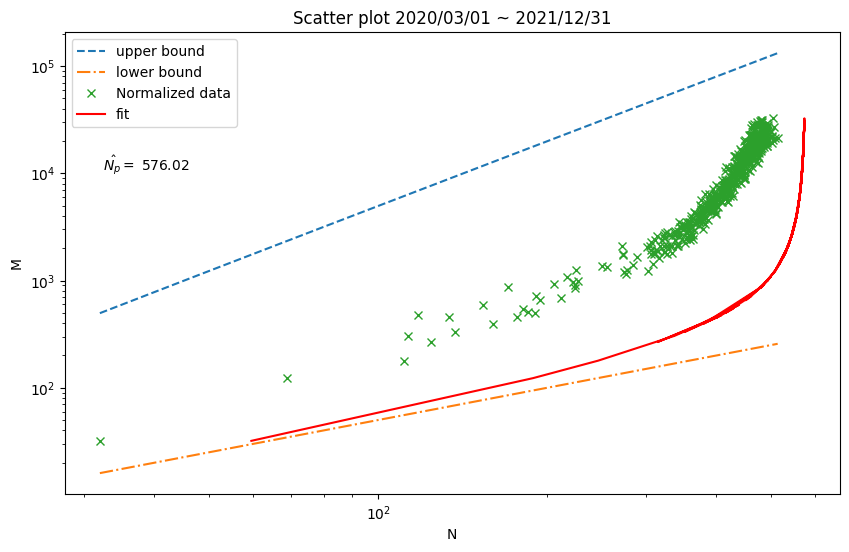

In [52]:
nn = len(left["node_norm"]) - 1
xmin = min(left["node_norm"])
xmax = max(left["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

Np_norm_hat = res.x[0]
Np_norm_hat = round(Np_norm_hat, 2)
print("+------------------+")
kappa_norm_estimated = []
for i in range(len(x)):
    kappa_norm_estimated.append( ((8 * left["edge_norm"][i]) / (Np_norm_hat**2 - Np_norm_hat)) ) 

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2/(kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i])/2)**Np_norm_hat )) ) 
    M_norm.append( ((kappa_norm_estimated[i] * Np_norm_hat**2) - (kappa_norm_estimated[i] * Np_norm_hat) ) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm,M_norm,label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [28]:
Np = 576
kappa = 0.00077

a = kappa / 2
kappaNp = kappa * Np

N = Np * ((1 - ((2 / kappaNp) * (1 - ((1 - a)**Np)) )))
M = (kappa * Np * (Np - 1)) / 8

In [48]:
# re-modeling
def ff(x, Np):
    return Np * ((1 - ((Np*(Np-1))/(4*x)) * (1 - (1 - ((4*x)/(Np*(Np-1)))**Np ) ) ))

In [49]:
# ff関数からヤコビアンを計算
def jac(x, Np):
    return (Np**2 * (Np-1)**2 * (4*x)**(Np-1) * (Np*(Np-1) - 4*x*Np + 4*x)) / (4*x)**(Np+1)

In [53]:
# df_rightを分析する
node_right, edge_right, timestamp_right = return_nm(df_right)
# node_leftとedge_leftを組みにしてdf_leftを作成
right = pd.DataFrame({'node': node_right, 'edge': edge_right})
# df_leftのnodeを昇順にして並び替え
right = right.sort_values(by='node')


# 正規化する
right["node_norm"] = right["node"] - right["node"].min() + 2
right["edge_norm"] = right["edge"] - right["edge"].min() + 1

# 一番最初の行を削除
right = right.drop(0)

# インデックスを振り直す
right = right.reset_index(drop=True)

In [55]:
right = right.drop(0)
right = right.reset_index(drop=True)
right.head()

,node,edge,node_norm,edge_norm
0,201,340,41,78
1,213,378,53,116
2,224,479,64,217
3,346,857,186,595
4,349,1481,189,1219


916.4553551851883
+------------------+
|      DONE        |
+------------------+
| Np:  916.46
| N max:  584
| kappa:  0.0007437580892601809
| N:  139.72177247336012
| M:  78.00000000000001
+------------------+


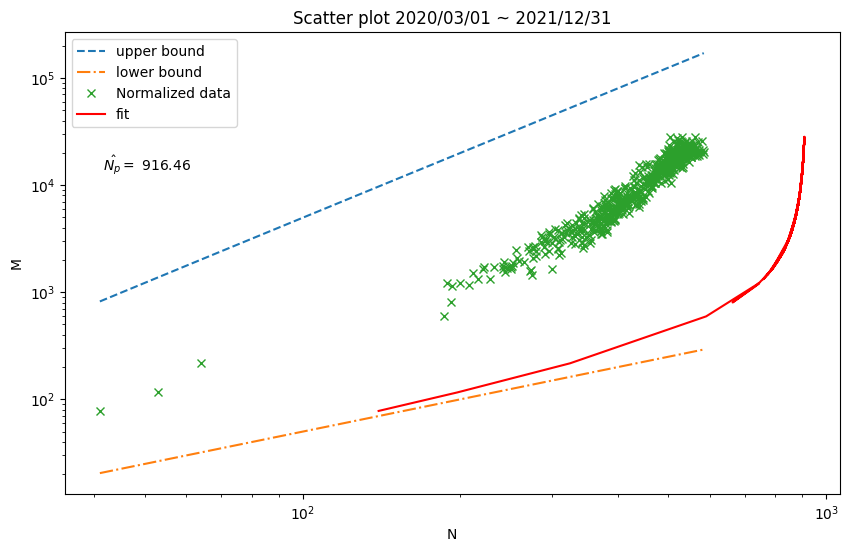

In [59]:
nn = len(right["node_norm"]) - 1
xmin = min(right["node_norm"])
xmax = max(right["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

res = optimize.least_squares(residual_f, x0=[600], args=(right["edge_norm"], right["node_norm"]))
print(res.x[0])

Np_norm_hat = res.x[0]
Np_norm_hat = round(Np_norm_hat, 2)
print("+------------------+")
kappa_norm_estimated = []
for i in range(len(right["edge_norm"])):
    kappa_norm_estimated.append( ((8 * right["edge_norm"][i]) / (Np_norm_hat**2 - Np_norm_hat)) ) 

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2/(kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i])/2)**Np_norm_hat )) ) 
    M_norm.append( ((kappa_norm_estimated[i] * Np_norm_hat**2) - (kappa_norm_estimated[i] * Np_norm_hat) ) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", right["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(right["node_norm"], right["edge_norm"], "x", label='Normalized data')
plt.plot(N_norm,M_norm,label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [64]:
# model1
nn = len(right["node_norm"]) - 1
xmin = min(right["node_norm"])
xmax = max(right["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

res = optimize.least_squares(residual_f2, x0=[10], args=(right["edge_norm"], right["node_norm"]))
print(res.x[0])

kappa_hat = res.x[0]
kappa_hat = round(kappa_hat, 2)
print("+------------------+")
Np_estimated = []
for i in range(len(right["edge_norm"])):
    Np_estimated.append( (1 + np.sqrt(1 + ((32 * np.abs(right["edge_norm"][i])) / np.abs(kappa_hat))) ) / 2 )

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_estimated[i] * (1 - (2/(kappa_hat*Np_estimated[i])) * (1 - (1 - (kappa_hat)/2)**Np_estimated[i] )) ) 
    M_norm.append( ((kappa_hat * Np_estimated[i]**2) - (kappa_hat * Np_estimated[i]) ) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_estimated[0])
print("| N max: ", right["node_norm"].max())
print("| kappa: ", kappa_hat[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(right["node_norm"], right["edge_norm"], "x", label='Normalized data')
plt.plot(N_norm,M_norm,label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

ValueError: Residuals are not finite in the initial point.

In [67]:
res = optimize.curve_fit(f2, xdata=right["edge_norm"], ydata=right["node_norm"])
print(res[0][0])

3.5120670016727854e-06
